# Краевая задача

### В общем виде:

$L[y]=y''+p(x)y+q(x)y=f(x)$

$l_a[y]=\alpha_0y(a)+\alpha_1y'(a)=A$

$l_b[y]=\beta_0y(b)+\beta_1y'(b)=B$

for $x\in[a,b]$

## Задача 1

$\frac{d^2y}{dx^2}-\frac{dy}{dx}\ln(x)-2y=1$ for $x \in [0.5,1.5]$

### с заданными граничными условиями:

$y(0.5)+y'(0.5)=1$, $y(1.5)-y'(1.5)=0$

1.1. Solve this problem using finite difference method of the second order. Use the uniform grid. **Is this method stable for step size $h=0.125$?** Find number of grid points required to achieve accuracy of the order of 1e-4.

1.2. Use the first order one-sided numerical approximation for the first derivative and write a new scheme. Find number of grid points required to achieve accuracy of the order of 1e-4.

1.3. Plot the solutions of both methods on the same figure. Compare results and discuss differences (if occurs).

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.integrate import simps
from IPython.display import Image
from IPython.core.display import HTML

plt.style.use('ggplot')
%matplotlib notebook
%matplotlib inline

### Решим уравнение методом разностных схем второго и первого порядка.

1) Сначала второй порядок. Производные аппроксимируем так:

$y'(x) = \frac{y_{i+1}-y_{i-1}}{2h}+O(h^2)$, где $y_{i+1} = y(x+h)$, $h=const$ - шаг сетки

$y''(x) = \frac{y_{i+1}+2y_i-y_{i-1}}{h^2}+O(h^2)$

На границах отрезка с первой производной поступим чуть хитрее, сохранив при этом порядок точности приближения производной:

$y'(x) = \frac{-3y_i+4y_{i+1}-y_{i+2}}{2h}+O(h^2), x=a$

$y'(x) = \frac{3y_i-4y_{i-1}+y_{i-2}}{2h}+O(h^2), x=b$

2) Первый порядок. Всё похоже, изменится только определение первой производной:

$y'(x) = \frac{y_i - y_{i-1}}{h}+O(h), x \in (a, b]$

$y'(x) = \frac{y_{i+1} - y_i}{h}+O(h), x=a$

In [2]:
def SecondOrderScheme(a, b, A, B, alpha, beta, p, q, f, N=100):
    # in:
    # a,b - float, limits of x, N - int, number of grid points
    # A,B - float, boundary values
    # alpha, beta - array of float, coefficients for boundary conditions in general case
    # p(x), g(x), f(x) - functions from general equation

    # you can construct matrix of the system and use scipy.linalg.solve method to solve it: y=solve(M,f)

    # out:
    # y - array of float, solution of the BVP
    # nodes - uniform grid
    nodes = np.linspace(a, b, N + 1)  # N+1 elements in array, index from 0 to N
    h = nodes[1] - nodes[0]  # uniform grid

    # to solve problem let's construct LES: C*y = b

    # C is a tridiagonal coefficient matrix:
    upper_diag = 1 / h ** 2 + p(nodes) / (2 * h)  # C[i,i+1]
    main_diag = -2 / h ** 2 + q(nodes)  # C[i,i]
    lower_diag = 1 / h ** 2 - p(nodes) / (2 * h)  # C [i,i-1]

    C = np.diagflat(upper_diag[:N], k=1) + \
        np.diag(main_diag) + np.diagflat(lower_diag[1:], k=-1)

    b = f(nodes)

    # consider boundary cond. in C matrix & b vector:
    C[0, 0] = alpha[0] - 3/2 * alpha[1] / h
    C[0, 1] = 2*alpha[1] / h
    C[0, 2] = -alpha[1] / (2*h)

    b[0] = A

    C[N, N] = beta[0] + 3/2 * beta[1]/h
    C[N, N-1] = -2 * beta[1]/h
    C[N, N-2] = beta[1] / (2*h)

    b[N] = B


    y = LA.solve(C, b)

    return y, nodes

def FirstOrderScheme(a, b, A, B, alpha, beta, p, q, f, N=100):
    # in:
    # a,b - float, limits of x, N - int, number of grid points
    # A,B - float, boundary values
    # alpha, beta - array of float, coefficients for boundary conditions in general case
    # p(x), g(x), f(x) - functions from general equation

    # you can construct matrix of the system and use scipy.linalg.solve method to solve it: y=solve(M,f)

    # out:
    # y - array of float, solution of the BVP
    # nodes - uniform grid

    nodes = np.linspace(a, b, N + 1)  # N+1 elements in array, index from 0 to N
    h = nodes[1] - nodes[0]  # uniform grid

    # to solve problem let's construct LES: C*y = b

    # C is a tridiagonal coefficient matrix:

    upper_diag = 1 / h ** 2 * np.ones(N + 1)  # C[i,i+1]
    main_diag = -2 / h ** 2 + p(nodes) / h + q(nodes)  # C[i,i]
    lower_diag = 1 / h ** 2 - p(nodes) / h  # C[i,i-1]

    C = np.diagflat(upper_diag[:N], k=1) + \
        np.diag(main_diag) + np.diagflat(lower_diag[1:], k=-1)

    # b vector from LSE
    b = f(nodes)

    # consider boundary cond. in C matrix & b vector:
    C[0, 0] = alpha[0] - alpha[1] / h
    C[0, 1] = alpha[1] / h

    b[0] = A

    C[N, N] = beta[0] + beta[1] / h
    C[N, N - 1] = -beta[1] / h

    b[N] = B

    y = LA.solve(C, b)
    return y, nodes

Теперь можем решить уравнение из задания 1.
### Метод второго порядка

In [3]:
# boundary cond.
alpha1 = np.array([1, 1])
beta1 = np.array([1, -1])

# functions from eq.
def p1(x):
    return -np.log(x)

def q1(x):
    return -2 * np.ones(len(x))

def f1(x):
    return np.ones(len(x))

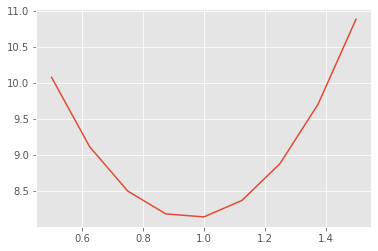

In [4]:
# 1.1
# try h = 0.125 -> N = (b-a)/h = 8
y, nodes = SecondOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=8)

plt.figure()
plt.plot(nodes, y)

Что об этом уравнении думает вольфрам:

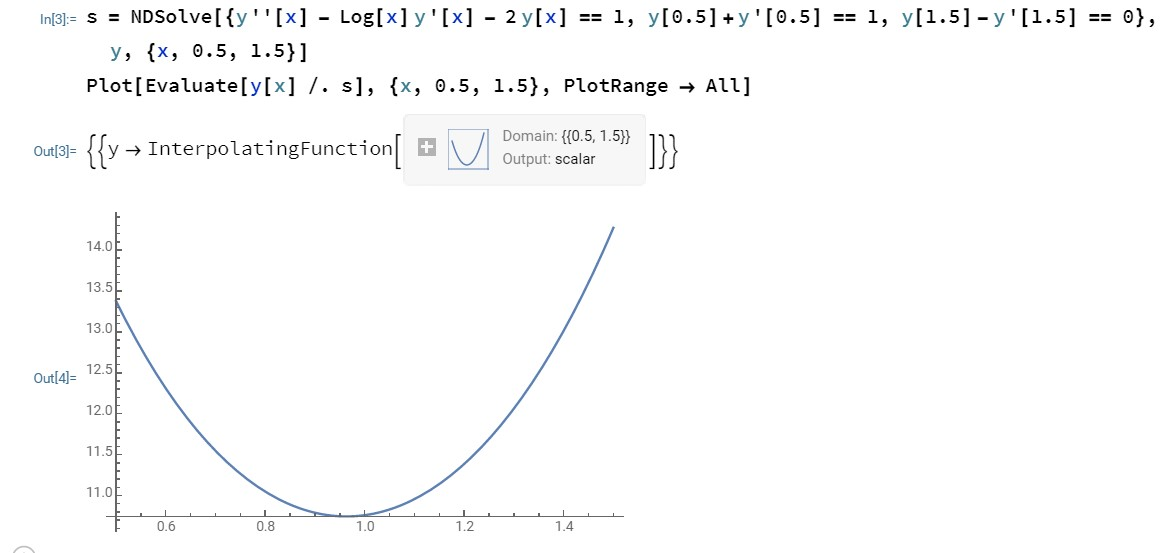

In [5]:
PATH = "D:/Документы/Вычфиз/hw10/"
Image(filename=PATH + "eq1.jpg", width=750, height=750)

$h = 0.125$ - слишком большой шаг, метод работает нестабильно, решение получается далёкое от реальности.

Найдём количество узлов $N$, необходимое для достижения относительной точности 1e-4. Относительную точность* считаем как максимум ошибки по узлам для решений с $N$ и $2N$ узлов.

*чтобы считать относительную точность, после увеличения числа узлов сетки в 2 раза будем из "нового" решения выкидывать каждый второй элемент.

In [6]:
N_try = 10
y_new = SecondOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=N_try)[0]
y_old = np.zeros(6)
err = np.max(np.abs(y_old - y_new[::2])) # dim(y_new) = 2*dim(y_old) 

while err > 1e-3:
    N_try = 2*N_try
    y_old = y_new
    y_new = SecondOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=N_try)[0]
    err = np.max(np.abs(y_old - y_new[::2]))

print('Error: {0}, N = {1}'. format(err, N_try))

Error: 0.0006803733541147494, N = 1280


Для требуемой точности нужна сетка с $N\approx1280$.

### Теперь метод первого порядка

In [7]:
# 1.2
N_try = 10
y_new = FirstOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=N_try)[0]
y_old = np.zeros(6)
err = np.max(np.abs(y_old - y_new[::2]))

while err > 1e-1:
    N_try = 2*N_try
    y_old = y_new
    y_new = FirstOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=N_try)[0]
    err = np.max(np.abs(y_old - y_new[::2]))

print('Error: {0}, N = {1}'. format(err, N_try))

Error: 0.09860664142191666, N = 2560


В схеме с односторонней производной удаётся доползти до точности порядка 1e-2 на сетке с $N\approx2560$. Большей точности достигнуть не удаётся, возникают огромные матрицы и вылезает MemoryError. Вероятно это связано с тем, что в методе односторенней производной ошибка аппроксимации $\sim h$.

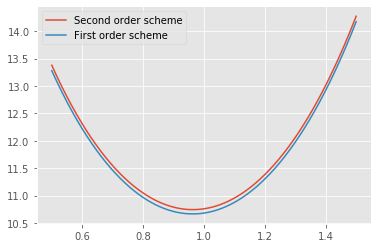

In [8]:
# 1.3
solution_scnd, grid_scnd = SecondOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=1280)
solution_frst, grid_frst = FirstOrderScheme(0.5, 1.5, 1, 0, alpha1, beta1, p1, q1, f1, N=2560)

plt.figure()
plt.plot(grid_scnd, solution_scnd, label='Second order scheme')
plt.plot(grid_frst, solution_frst, label='First order scheme')
plt.legend()

Точность порядка 1e-2 в методе FirstOrderScheme() достигается на сетке в *два раза* большей чем в методе SecondOrderScheme(), причём во втором случае точность уже порядка 1e-4. Метод с использованием односторонней производной, FirstOrderScheme(), даёт очень грубую оценку решения уравнения. Метод с двусторонней производной, SecondOrderScheme(), решает задачу лучше. 

## Задача 2

$\frac{d^2y}{dx^2}+2\frac{dy}{dx}-3xy=\frac{2-8x}{x^3}$ for $x \in [1,2]$

### with the boundary conditions:

$y(1)=1$, $y(2)=0.5$

2.1. Solve this problem using finite difference method of the second order. Find number of grid points required to achieve accuracy of the order of 1e-6.

2.2. Solve this problem using Galerkin method with power basis functions. Find number of grid points required to achieve accuracy of the order of 1e-6.

2.3. Plot the solutions of both methods on the same figure. Compare results and discuss differences (if occurs).

In [9]:
# functions from eq.
def p2(x):
    return 2*np.ones(len(x))

def q2(x):
    return -3 * x

def f2(x):
    return (2 - 8*x) / x**3

# boundary cond.
alpha2 = np.array([1, 0])
beta2 = np.array([1, 0])

Сначала решаем **методом разностных схем второго порядка**.

In [10]:
# 2.1
N_try = 10
y_new = SecondOrderScheme(1, 2, 1, 0.5, alpha2, beta2, p2, q2, f2, N=N_try)[0]
y_old = np.zeros(6)
err = np.max(np.abs(y_old - y_new[::2]))

while err > 1e-5:
    N_try = 2*N_try
    y_old = y_new
    y_new = SecondOrderScheme(1, 2, 1, 0.5, alpha2, beta2, p2, q2, f2, N=N_try)[0]
    err = np.max(np.abs(y_old - y_new[::2]))

print('Error: {0}, N = {1}'. format(err, N_try))

Error: 2.526021527948785e-06, N = 160


Нужная относительная точность достигается довольно быстро на сетке с $N=160$.

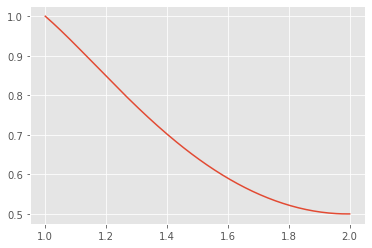

In [11]:
solution, nodes = \
    SecondOrderScheme(1, 2, 1, 0.5, alpha2, beta2, p2, q2, f2, N=160)
y_scndorder, nodes_scndorder = solution, nodes
plt.figure()
plt.plot(nodes, solution)

### Метод Галёркина
Общая идея:
1. Выбираем базисные функции $\phi_i$, отдельно задаём $\phi_0$.

Причём нужно учесть граничные условия:

$l_a(\phi_0)=A$, $l_a(\phi_i)=0$, $\forall i>0$

$l_b(\phi_0)=B$, $l_a(\phi_i)=0$, $\forall i>0$

2. Решение представляем в виде разложения по базису:

$y_n(x)=\phi_0+\sum_{j=1}^n c_i\phi_i(x)$

2. Переписываем исходное уравнение:

$Ly_n=f \; \rightarrow$ system $L\left(\sum_{i=1}^m c_i \phi_i \right) = f -L(\phi_0)$, где
$L(\phi_0)=\phi_0''+p(x)\phi_0'+q(x)\phi_0$

3. Получаем систему уравнений:

$\sum_j^n (L\phi_j,\phi_i) c_j=(f-L\phi_0(x),\phi_i) \; \rightarrow \sum_j M_{ij}c_j = d_i$

где $M_{ij}=(L\phi_{j+1}(x),\phi_i(x))=\int_a^b (\phi_{j+1}''+p(x)\phi_{j+1}'+q(x)\phi_{j+1})\cdot\phi_idx$,

$b_i=(f-L\phi_0(x),\phi_i(x))=\int_a^b (f(x)-\phi_0''-p(x)\phi_0'-q(x)\phi_0)\cdot\phi_idx$



Для решения **задачи 2** попробуем такие базисные функции:

$\phi_0 = \frac{1}{x}$

$\phi_k = (2-x)\cdot(1-x)^k$

In [13]:
# define base functions and its' derivatives

def phi0(x):
    return 1/x

def dphi0(x): # first derivative
    return -1/x**2

def ddphi0(x): # second derivative
    return 2/x**3

def phi(k, x):
    return (2-x)*(1-x)**k

def dphi(k, x):
    return (1-x)**(k-1) * (-1 + x + k*(x-2))

def ddphi(k, x):
    return -k*(1-x)**(k-2) * (k*(x-2) + x)

In [14]:
# 2.2
N = 100
a, b = 1, 2
nodes = np.linspace(a, b, N)

def Galerkin(Np):
    # in:
    # Np - int, number of base functions
    
    # out:
    # y - array of float, solution of the BVP
    
    # construct M matrix and d vector:
    M = np.zeros([Np, Np])
    d = np.zeros(Np)
    x = nodes[1:-1]
    for i in range(Np):
        d[i] = simps((f2(x) - ddphi0(x) - p2(x) * dphi0(x) - q2(x) * phi0(x)) * phi(i, x), x=x)
        for j in range(Np):
            M[i, j] = simps((ddphi(j+1, x) + p2(x) * dphi(j+1, x) + q2(x) * phi(j+1, x)) * phi(i, x), x=x)
            # print(i, 'row', j, 'col')

    # solve LES M*coeff = d to find Galerkin coefficients
    coeff = LA.solve(M, d)

    # get the solution
    y = phi0(nodes)
    for j in range(Np):
        y += coeff[j] * phi(j+1, nodes)
    return y

# let's find the M matrix size to the desired precision 1e-6
Np_try = 4
y_new = Galerkin(Np_try)
err = 1

while err > 1e-5:
    Np_try = Np_try + 1
    y_old = y_new
    y_new = Galerkin(Np_try)
    err = LA.norm(y_old-y_new)
    print('Error: {0}, N = {1}'. format(err, Np_try))

y_galerkin = y_new
nodes_galerkin = nodes

Error: 0.0026365688040866043, N = 5
Error: 0.00032578011184283183, N = 6
Error: 3.587195409737142e-05, N = 7
Error: 4.350178536750842e-06, N = 8


Относительная точность 1e-6 достигается при аппроксимации решения 8-ю базисными функциями.

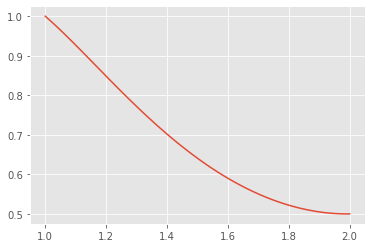

In [15]:
plt.figure()
plt.plot(nodes, y_galerkin)

Сравним решения, полученные разными методами.

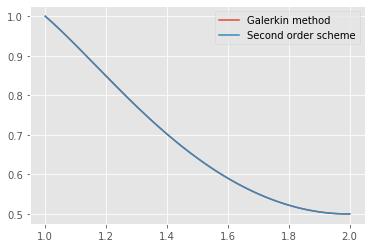

In [16]:
# 2.3
plt.figure()
plt.plot(nodes_galerkin, y_galerkin, label='Galerkin method')
plt.plot(nodes_scndorder, y_scndorder, label='Second order scheme')
plt.legend()

Оба метода довольно быстро сходятся к одному решению.

Что об этом думает вольфрам:

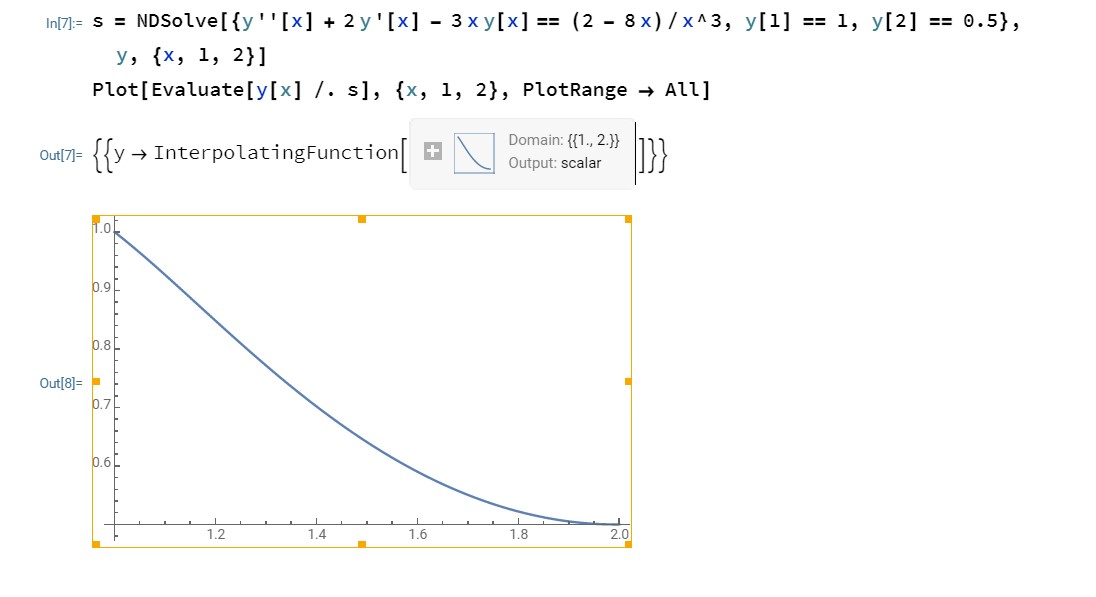

In [17]:
PATH = "D:/Документы/Вычфиз/hw10/"
Image(filename=PATH + "eq2.jpg", width=750, height=750)

Из графиков видно, что полученные решения довольно хорошо описывают реальность, если ею считать вольфрам :)